# 프로젝트: 한국어 데이터로 챗봇 만들기

# 목차
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기
- Step 3. SubwordTextEncoder 사용하기
- Step 4. 모델 구성하기
- Step 5. 모델 평가하기

In [27]:
# 주요 라이브러리 버전 확인
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

2.6.0


## Step 1. 데이터 수집하기

In [28]:
# 데이터 경로 설정
data_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/ChatbotData.csv')

print(os.path.exists(data_path))  # True가 출력되어야 정상!

True


In [29]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 10000
print("최대 샘플 수:", MAX_SAMPLES)

최대 샘플 수: 10000


## Step 2. 데이터 전처리하기
- songys/Chatbot_data는 CSV 파일 하나로 구성되어 있고, 'Q'(질문)와 'A'(답변)이 이미 쌍으로 정리되어 있음
- 이에 pandas로 질문과 답변을 한 줄씩 바로 읽어 전처리하였음

In [30]:
def preprocess_sentence(sentence):
    
    sentence = sentence.strip()  # 공백 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 분리
    sentence = re.sub(r'[" "]+', " ", sentence)         # 연속된 공백을 하나로
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)  # 한글, 숫자, 구두점 외의 문자는 공백으로 대체
    
    sentence = sentence.strip()
    return sentence

In [31]:
# 질문과 답변 데이터셋 로드 함수
def load_conversations():
    df = pd.read_csv(data_path)
    
    # 질문과 답변 리스트 생성
    inputs, outputs = [], []
    
    for idx, row in df.iterrows():
        if len(inputs) >= MAX_SAMPLES:
            break
        question, answer = row['Q'], row['A']
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
    
    return inputs, outputs

In [32]:
# 데이터 로드 및 전처리
questions, answers = load_conversations()

# 데이터 수 확인
print('전체 샘플 수:', len(questions))
print('전체 샘플 수:', len(answers))

전체 샘플 수: 10000
전체 샘플 수: 10000


In [33]:
# 전처리 샘플 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기

### 단어장(Vocabulary) 만들기

In [34]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [35]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 단어장 크기 (시작, 종료 토큰 포함)
VOCAB_SIZE = tokenizer.vocab_size + 2

print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)
print('단어장 크기 :', VOCAB_SIZE)

START_TOKEN의 번호 : [8856]
END_TOKEN의 번호 : [8857]
단어장 크기 : 8858


### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [36]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업 수행
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [8546, 3652, 7139]
정수 인코딩 후의 21번째 답변 샘플: [1761, 5697, 7, 4735, 115, 1]


In [37]:
# 샘플의 최대 허용 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [38]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 시작과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 조건에 맞는 데이터만 저장
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 패딩 적용
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [39]:
# 데이터셋 필터링 및 패딩 적용
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수:', len(questions))
print('필터링 후의 답변 샘플 개수:', len(answers))

단어장의 크기 : 8858
필터링 후의 질문 샘플 개수: 10000
필터링 후의 답변 샘플 개수: 10000


### 교사 강요(Teacher Forcing) 사용하기

In [40]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# tf.data.Dataset으로 변환
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더 입력
    },
    {
        'outputs': answers[:, 1:]     # 디코더 출력 (레이블)
    },
))

# 셔플 및 배치 적용
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [41]:
# 임의의 샘플 확인
print('정수 인코딩된 질문 샘플:', questions[11])
print('정수 인코딩된 답변 샘플:', answers[11])

# 정수 인코딩된 샘플을 다시 디코딩하여 확인
print('디코딩된 질문:', tokenizer.decode([i for i in questions[11] if i not in [0, START_TOKEN[0], END_TOKEN[0]]])) # START_TOKEN과 END_TOKEN을 제외한 토큰만 디코딩
print('디코딩된 답변:', tokenizer.decode([i for i in answers[11] if i not in [0, START_TOKEN[0], END_TOKEN[0]]]))

정수 인코딩된 질문 샘플: [8856  516  805 8857    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
정수 인코딩된 답변 샘플: [8856   57  595  141    3    1 8857    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
디코딩된 질문: 가끔 궁금해
디코딩된 답변: 그 사람도 그럴 거예요 .


## Step 4. 모델 구성하기

### 포지셔널 인코딩 (Positional Encoding)

In [42]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position 
        self.d_model = d_model 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각 위치에 대한 각도를 계산
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cos 값을 하나의 배열로 병합
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        # HDF5 직렬화를 위한 설정 반환
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):  # from_config() 추가 (모델 재로딩 가능하게)
        return cls(**config)

### 스케일드 닷 프로덕트 어텐션 (Scaled Dot Product Attention)

In [43]:
def scaled_dot_product_attention(query, key, value, mask):
  # Q와 K의 내적
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화 (스케일링)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax로 가중치 계산
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 가중치를 V에 적용
  output = tf.matmul(attention_weights, value)
  return output

### 멀티헤드 어텐션 (Multi-Head Attention)

In [44]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # 멀티 헤드로 분리
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만들기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)
        return outputs

    def get_config(self):
        # HDF5 직렬화를 위한 설정 반환
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

### 패딩 마스킹(Padding Masking)

In [45]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [46]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더

In [47]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [48]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

In [49]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [50]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 전체 트랜스포머 모델 구성

In [51]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
  # 내부에 패딩 마스크도 포함
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Step 5. 모델 평가하기

### 모델 훈련

In [52]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3321856     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [53]:
# 손실 함수(Loss function)
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

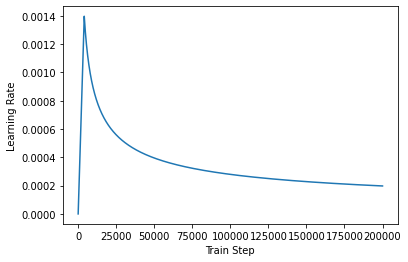

In [54]:
# 커스텀 된 학습률(Learning rate)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(CustomSchedule, self).__init__(**kwargs)
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):  # get_config() 추가 (직렬화 가능하게)
        return {"d_model": int(self.d_model.numpy()), "warmup_steps": self.warmup_steps}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# 학습률 스케줄링 확인
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [55]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [56]:
# 훈련하기
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
157/157 [==============================] - 15s 54ms/step - loss: 1.4207 - accuracy: 0.0272
Epoch 2/10
157/157 [==============================] - 8s 54ms/step - loss: 1.1891 - accuracy: 0.0493
Epoch 3/10
157/157 [==============================] - 8s 54ms/step - loss: 0.9937 - accuracy: 0.0498
Epoch 4/10
157/157 [==============================] - 9s 55ms/step - loss: 0.9039 - accuracy: 0.0517
Epoch 5/10
157/157 [==============================] - 9s 54ms/step - loss: 0.8515 - accuracy: 0.0549
Epoch 6/10
157/157 [==============================] - 9s 55ms/step - loss: 0.8014 - accuracy: 0.0578
Epoch 7/10
157/157 [==============================] - 9s 55ms/step - loss: 0.7481 - accuracy: 0.0618
Epoch 8/10
157/157 [==============================] - 9s 56ms/step - loss: 0.6883 - accuracy: 0.0676
Epoch 9/10
157/157 [==============================] - 9s 56ms/step - loss: 0.6218 - accuracy: 0.0751
Epoch 10/10
157/157 [==============================] - 9s 56ms/step - loss: 0.5490 - accur

In [57]:
import os
import pickle
import tensorflow as tf

# 저장 경로 (HDF5 포맷)
model_save_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/model.h5")

# 모델 저장 (HDF5 포맷)
model.save(model_save_path)
print(f"✅ 모델 저장 완료: {model_save_path}")

# 토크나이저 저장
tokenizer_save_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/tokenizer.pickle")
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)
print(f"✅ 토크나이저 저장 완료: {tokenizer_save_path}")

✅ 모델 저장 완료: /aiffel/aiffel/transformer_chatbot/model/model.h5
✅ 토크나이저 저장 완료: /aiffel/aiffel/transformer_chatbot/model/tokenizer.pickle


### 모델 평가

In [58]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 됨
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [59]:
# 임의의 입력 문장에 대해 챗봇의 대답을 얻는 sentence_generation() 함수
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받음
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [60]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 많이 지쳤나봐요 .


'많이 지쳤나봐요 .'

In [61]:
sentence_generation("어제는 속상했어.")

입력 : 어제는 속상했어.
출력 : 좋은 사람 만나세요 .


'좋은 사람 만나세요 .'

In [62]:
# Perplexity 계산 함수
def calculate_perplexity(model, dataset):
    total_loss = 0
    total_count = 0
    
    for batch in dataset:
        inputs, targets = batch
        predictions = model(inputs, training=False)
        
        # 손실 값 계산
        loss = loss_function(targets['outputs'], predictions)
        total_loss += loss.numpy()
        total_count += 1

    # Perplexity 계산
    perplexity = np.exp(total_loss / total_count)
    return perplexity

# Perplexity 측정
perplexity = calculate_perplexity(model, dataset)
print(f"\n✅ Perplexity: {perplexity:.4f}") # 1에 가까울수록 이상적. 20~30이면 일반적으로 사용 가능한 수준


✅ Perplexity: 1.5692


In [66]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# BLEU 점수 계산 함수
def calculate_bleu_score(references, candidates):
    smoothie = SmoothingFunction().method4
    scores = []
    for ref, cand in zip(references, candidates):
        score = sentence_bleu([ref.split()], cand.split(), smoothing_function=smoothie)
        scores.append(score)
    return np.mean(scores)

# 테스트 데이터셋
test_sentences = [
    "오늘 날씨 어때?",
    "기분이 안 좋아.",
    "주말에 뭐 할까?",
    "안녕!"
]

# 정답 문장 (직접 작성하거나 평가용 데이터셋 사용)
reference_sentences = [
    "오늘 날씨가 좋아요.",
    "기분이 안 좋군요. 무슨 일 있었나요?",
    "주말에 산책이나 영화 보는 건 어때요?",
    "안녕하세요!"
]

# 모델이 예측한 문장
predicted_sentences = [sentence_generation(sentence) for sentence in test_sentences]

# BLEU 점수 계산
bleu_score = calculate_bleu_score(reference_sentences, predicted_sentences)
print(f"\n✅ BLEU Score: {bleu_score:.4f}") # 0.3 이상이면 꽤 좋음

입력 : 오늘 날씨 어때?
출력 : 멋진 말이에요 .
입력 : 기분이 안 좋아.
출력 : 저도 싶어요 .
입력 : 주말에 뭐 할까?
출력 : 같이 가보세요 .
입력 : 안녕!
출력 : 저도 좋아해요 .

✅ BLEU Score: 0.0000


In [67]:
from rouge_score import rouge_scorer

# ROUGE 점수 계산 함수
def calculate_rouge_score(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = [], [], []

    for ref, cand in zip(references, candidates):
        scores = scorer.score(ref, cand)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)

    return np.mean(rouge1), np.mean(rouge2), np.mean(rougeL)

# ROUGE 점수 계산
rouge1, rouge2, rougeL = calculate_rouge_score(reference_sentences, predicted_sentences)
print(f"\n✅ ROUGE-1: {rouge1:.4f}") # 0.5 이상이면 양호
print(f"✅ ROUGE-2: {rouge2:.4f}") # 0.3 이상이면 양호
print(f"✅ ROUGE-L: {rougeL:.4f}") # 0.4 이상이면 양호


✅ ROUGE-1: 0.0000
✅ ROUGE-2: 0.0000
✅ ROUGE-L: 0.0000


In [69]:
import os
import pickle
import tensorflow as tf

# ✅ 모델 및 토크나이저 경로
model_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/model.h5")
tokenizer_path = os.path.expanduser("~/aiffel/transformer_chatbot/model/tokenizer.pickle")

# ✅ 커스텀 레이어 등록 후 모델 로드
custom_objects = {
    "PositionalEncoding": PositionalEncoding,
    "MultiHeadAttention": MultiHeadAttention,
    "CustomSchedule": CustomSchedule
}
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

# 토크나이저 로드
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# 챗봇 설정
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
MAX_LENGTH = 40

def chatbot():
    """실제 챗봇 실행"""
    while True:
        user_input = input("🧑‍💻 당신: ").strip()
        if user_input.lower() == "종료":
            print("🔴 챗봇을 종료합니다. 👋")
            break
        response = sentence_generation(user_input)
        print(f"🤖 챗봇: {response}")

def sentence_generation(sentence):
    """입력 문장에 대한 챗봇 응답 생성"""
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence.strip()) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    for _ in range(MAX_LENGTH):
        predictions = model([sentence, output], training=False)
        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        
        # int64 → int32 변환
        predicted_id = tf.cast(predicted_id, dtype=tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        output = tf.concat([output, predicted_id], axis=-1)

    return tokenizer.decode([i for i in tf.squeeze(output) if i < tokenizer.vocab_size])

if __name__ == "__main__":
    chatbot()

🧑‍💻 당신: 안녕?
🤖 챗봇: 좋은 곳으로 가보세요 .
🧑‍💻 당신: 어디로?
🤖 챗봇: 저도 좋아해요 .
🧑‍💻 당신: 왜 좋아?
🤖 챗봇: 저도 같이 가보세요 .
🧑‍💻 당신: 어디 가고싶어?
🤖 챗봇: 좋은 사람 만나세요 .
🧑‍💻 당신: 종료
🔴 챗봇을 종료합니다. 👋


## 모델 성능 개선
**사전 학습 모델(KETI-AIR/ke-t5-small) 사용**

### 환경 설정 및 라이브러리 설치

In [70]:
# 필요한 라이브러리 설치
!pip install transformers datasets torch torchvision torchaudio fastapi uvicorn
!pip install rouge-score nltk

In [71]:
import os
import torch
import re
from datasets import load_dataset
from transformers import AutoTokenizer

### 데이터 로드 및 전처리

In [72]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [73]:
# 사전학습된 토크나이저 로드 (KE-T5 모델 사용)
model_name = 'KETI-AIR/ke-t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [74]:
# 데이터셋 경로 설정 및 로드
data_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/ChatbotData.csv')

# 파일 존재 여부 확인
if not os.path.exists(data_path):
    raise FileNotFoundError(f"데이터 파일을 찾을 수 없습니다: {data_path}")
    
# 데이터셋 로드 (csv 형식 지정)
dataset = load_dataset('csv', data_files={'train': data_path})

  0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
# 최대 시퀀스 길이 설정
MAX_LENGTH = 40  

# 전처리 함수
def preprocess_function(examples):
    # 질문과 답변 추출
    inputs = [q for q in examples['Q']]
    targets = [a for a in examples['A']]
    
    # 입력과 출력 모두 토크나이즈
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding='max_length')

    # 타겟(답변)도 토크나이즈
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_LENGTH, truncation=True, padding='max_length')

    # 모델 입력에 레이블 추가
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# 데이터셋에 전처리 적용
tokenized_dataset = dataset.map(preprocess_function, batched=True)

print(tokenized_dataset)

  0%|          | 0/12 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['A', 'Q', 'attention_mask', 'input_ids', 'label', 'labels'],
        num_rows: 11823
    })
})


### 데이터셋 분할 및 DataLoader 생성

In [76]:
from torch.utils.data import DataLoader

# 'train' 데이터셋 선택
dataset = tokenized_dataset['train']

# 데이터셋 분할 (90% 학습, 10% 평가)
train_size = int(0.9 * len(dataset))
train_dataset = dataset.select(range(train_size))
eval_dataset = dataset.select(range(train_size, len(dataset)))

# PyTorch DataLoader를 위해 형식 변환
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# DataLoader 생성
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)

print(f"Train DataLoader: {len(train_dataloader)} batches")
print(f"Eval DataLoader: {len(eval_dataloader)} batches")

Train DataLoader: 665 batches
Eval DataLoader: 74 batches


### 모델 학습 및 평가

In [77]:
from transformers import AutoModelForSeq2SeqLM, Trainer, TrainingArguments

# 사전학습된 모델 로드
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# 모델 학습
trainer.train()

The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: A, Q.
***** Running training *****
  Num examples = 10640
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1995


Epoch,Training Loss,Validation Loss
1,15.730100,10.907944
2,1.837300,1.973964
3,1.686800,1.822395


The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: A, Q.
***** Running Evaluation *****
  Num examples = 1183
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-665
Configuration saved in ./results/checkpoint-665/config.json
Model weights saved in ./results/checkpoint-665/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1330] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: A, Q.
***** Running Evaluation *****
  Num examples = 1183
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1330
Configuration saved in ./results/checkpoint-1330/config.json
Model weights saved in ./results/checkpoint-1330/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1995] due to args.save_total_limit
The following columns in the evaluati

TrainOutput(global_step=1995, training_loss=14.767111160163592, metrics={'train_runtime': 306.8553, 'train_samples_per_second': 104.023, 'train_steps_per_second': 6.501, 'total_flos': 337547840716800.0, 'train_loss': 14.767111160163592, 'epoch': 3.0})

### 학습된 모델 저장

In [78]:
# 모델과 토크나이저 저장
model.save_pretrained("./finetuned_model")
tokenizer.save_pretrained("./finetuned_model")

Configuration saved in ./finetuned_model/config.json
Model weights saved in ./finetuned_model/pytorch_model.bin
tokenizer config file saved in ./finetuned_model/tokenizer_config.json
Special tokens file saved in ./finetuned_model/special_tokens_map.json
Copy vocab file to ./finetuned_model/spiece.model


('./finetuned_model/tokenizer_config.json',
 './finetuned_model/special_tokens_map.json',
 './finetuned_model/spiece.model',
 './finetuned_model/added_tokens.json',
 './finetuned_model/tokenizer.json')

### 모델 평가

In [79]:
import torch

# 모델을 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습된 모델과 토크나이저 로드
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "./finetuned_model"  # 저장된 모델 경로
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

MAX_LENGTH = 40  # 최대 문장 길이


def generate_response(input_text):
    """KE-T5 모델을 사용해 입력 문장에 대한 응답을 생성"""
    # 입력 텍스트 토크나이즈 및 GPU 이동
    inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)

    # 응답 생성
    outputs = model.generate(inputs, max_length=MAX_LENGTH, num_beams=5, early_stopping=True)

    # 생성된 토큰을 문장으로 디코딩
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


# 챗봇 실행 함수
def chatbot():
    print("챗봇을 시작합니다. '종료'라고 입력하면 대화가 종료됩니다.")

    while True:
        user_input = input("당신: ")

        if user_input.strip() == "종료":
            print("챗봇을 종료합니다. 안녕히 가세요!")
            break

        response = generate_response(user_input)
        print(f"챗봇: {response}")


# 챗봇 실행
if __name__ == "__main__":
    chatbot()

Didn't find file ./finetuned_model/added_tokens.json. We won't load it.
loading file ./finetuned_model/spiece.model
loading file ./finetuned_model/tokenizer.json
loading file None
loading file ./finetuned_model/special_tokens_map.json
loading file ./finetuned_model/tokenizer_config.json
loading configuration file ./finetuned_model/config.json
Model config T5Config {
  "_name_or_path": "KETI-AIR/ke-t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "use_cache": true,
  "vocab_size": 64128
}



챗봇을 시작합니다. '종료'라고 입력하면 대화가 종료됩니다.
당신: 안녕?
챗봇: 아예 freely십니까예요.
당신: 이름이 뭐야?
챗봇: 아예 freely세요.
당신: 아예는 왜 하는거야?
챗봇: 아예 freely세요.
당신: 음,,
챗봇: 아예 freely 거요예요.
당신: 그게 무슨 뜻이야?
챗봇: 마찬가지다예요.
당신: 종료
챗봇을 종료합니다. 안녕히 가세요!
